In [1]:
import sys
import time
import matplotlib.pyplot as plt
import wordninja
import networkx as nx
import re

from pullnet import PullNet
from graftnet import GraftNet
from pullnet_data_loader import DataLoader
from fpnet_data_loader import FpNetDataLoader
from relreasoner_data_loader import RelReasonerDataLoader
from fpnet import FactsPullNet
from util import *
from multiprocessing.pool import Pool
from preprocessing import use_helper
from collections import defaultdict
from string import punctuation
from preprocessing.process_complex_webq import clean_text
from collections import defaultdict


import warnings
warnings.filterwarnings("ignore")

In [2]:
cfg = get_config('config/complexwebq.yml')
word2id = load_dict(cfg['data_folder'] + cfg['word2id'])
relation2id = load_dict(cfg['data_folder'] + cfg['relation2id'])
entity2id = load_dict(cfg['data_folder'] + cfg['entity2id'])
num_hop = 1

In [4]:
train_data = load_json(cfg['data_folder'] + 'complex_train_processed2.json')
dev_data = load_json(cfg['data_folder'] + 'complex_dev_processed2.json')
test_data = load_json(cfg['data_folder'] + 'complex_test_processed2.json')

In [13]:
len([e for e in train_data+dev_data if len(e['entities']) == 1]) / len(train_data + dev_data)

0.5389306117209064

In [4]:
# Stastistic of the training+dev data pattern.
is_entity = lambda x: x.startswith('m.') or x.startswith('g.')

def _bfs(g, start):

    graph = nx.Graph()
    for s in g:
        for p in g[s]:
            for o in g[s][p]:
                graph.add_edge(s, o, data=p)
    graph = graph.to_undirected()
    shortest_path = nx.shortest_path(graph, start, '?x')
    relation = []
    for i in range(len(shortest_path) - 1):
        u, v = shortest_path[i], shortest_path[i + 1]
        data = graph.get_edge_data(u, v)['data']
        if i == 0:
            relation.append(u)
        relation.append(data)
        relation.append(v)

    return relation

def apply_mask(paths):
    max_len = 0
    for i in range(len(paths)):
        paths[i][0] = chr(ord('A') + i)
        for j in range(1, len(paths[i]), 2):
            paths[i][j] = ('r_%d^{(%d)}' % (i, j // 2 + 1))
        # for j in range(2, len(paths[i]) - 1, 2):
        #     paths[i][j] = ('e_%d^{(%d)}' % (i, j // 2))
        max_len = max(max_len, len(paths[i]))
    
    tables = [['' for _ in range(max_len)] for _ in range(len(paths))]
    for i in range(len(paths)):
        for j in range(max_len - 1, -1, -1):
            if (max_len - 1 - j) < len(paths[i]):
                tables[i][j] = paths[i][-(max_len - j)]
    for j in range(max_len):
        lens = defaultdict(int)
        for i in range(len(paths)):
            if tables[i][j] == '':
                continue
            lens[tables[i][j]] += 1
        for i in range(len(paths)):
            if lens[tables[i][j]] > 1:
                tables[i][j] = '|%s|' % tables[i][j]
    for i in range(len(paths)):
        tables[i] = ' '.join(tables[i]).strip()
    return '\n'.join(list(sorted(tables)))

def _analyse_pattern(pattern):
    pattern = pattern.replace('PREFIX ns: <http://rdf.freebase.com/ns/>', '').replace('SELECT DISTINCT ?x', '') \
        .replace('FILTER (!isLiteral(?x) OR lang(?x) = \'\' OR langMatches(lang(?x), \'en\'))', '')\
        .replace('FILTER (?x != ?c)', '')\
        .replace('{', '{\n')\
        .replace('}', '}\n')
    pattern = '\n'.join([e.strip().replace('ns:', '') for e in pattern.split('\n') if e.strip() and not e.strip().startswith('FILTER (?x !=') and not e.strip().startswith('WHERE') and e.strip() != '}'])

    result = -1
    order_by_pattern = 0
    filter_pattern = 1
    union_pattern = 2
    adj_map = dict()
    entities = set()
    for p in pattern.split('\n'):
        if p.startswith('ORDER BY'):
            result = order_by_pattern
            break
        if p.startswith('FILTER('):
            result = filter_pattern
            break
        if p.startswith('UNION'):
            result = union_pattern
            break
        tup = p.split()
        if len(tup) < 4:
            continue
        tup = tup[:4]
        s, p, o, _ = tup
        if is_entity(s):
            entities.add(s)
        if is_entity(o):
            entities.add(o)
        if s not in adj_map:
            adj_map[s] = dict()
        if p not in adj_map[s]:
            adj_map[s][p] = dict()
        if o not in adj_map[s][p]:
            adj_map[s][p][o] = 0
        if o not in adj_map:
            adj_map[o] = dict()
        if p not in adj_map[o]:
            adj_map[o][p] = dict()
        if s not in adj_map[o][p]:
            adj_map[o][p][s] = 1
    entities = list(entities)
    paths = []
    for e in entities:
        try:
            path = _bfs(adj_map, e)
        except Exception as e2:
            continue
        paths.append(path)
    return apply_mask(paths), result
    

pattern_cnt = defaultdict(int)
p_cnt = defaultdict(int)
for i, e in tqdm(enumerate((train_data + dev_data))):
    # print(e['sparql'])
    # print(_analyse_pattern(e['sparql']))
    # print()
    try:
        masked, p = _analyse_pattern(e['sparql'])
        pattern_cnt[masked] += 1
        p_cnt[p] += 1
    except Exception as e2:
        print(e['sparql'])
        print(e2)
        print(i)
        break

# for l in list(sorted(pattern_cnt.items(), key=lambda x: x[1], reverse=True)):
#     print()
#     print(l[0])
#     print('%.2f%%' % (100 * l[1] / len(train_data + dev_data)))

for l in list(sorted(p_cnt.items(), key=lambda x: x[1], reverse=True)):
    print()
    print(l[0])
    print('%.2f%%' % (100 * l[1] / len(train_data + dev_data)))

31158it [00:03, 9566.67it/s]


-1
86.04%

1
6.59%

0
6.20%

2
1.17%


In [10]:
avg_entities = 0
for i, e in tqdm(enumerate((train_data + dev_data))):
    avg_entities += len(e['entities'])
avg_entities / len(train_data + dev_data)

31158it [00:00, 1368369.45it/s]


1.5214070222735734

In [15]:
avg_len_relation_path = 0
total_relation_paths = 0
for i, e in tqdm(enumerate((train_data + dev_data))):
    for p in e['ground_truth_path']:
        avg_len_relation_path += (len(p) - 1) // 2
        total_relation_paths += 1
avg_len_relation_path / total_relation_paths

31158it [00:00, 608813.71it/s]


2.363017846889576

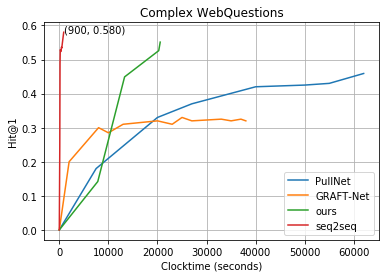

In [5]:

x1 = [0, 7500, 20000, 27000, 40000, 50000, 55000, 62000]
y1 = [0, 0.18, 0.33, 0.37, 0.42, 0.425, 0.43, 0.459]
x2 = [0, 2000, 8000, 10000, 13000, 20000, 23000, 25000, 27000, 33000, 35000, 37000, 38000]
y2 = [0, 0.2, 0.3, 0.285, 0.31, 0.32, 0.31, 0.33, 0.32, 0.325, 0.32, 0.325, 0.32]
x3 = [0, 7840, 13300, 20256, 20256 + 300]
y3 = [0, 0.142, 0.449, 0.526, 0.551]
x4 = [0, 101, 151, 201, 251, 300, 351, 451,  501,  900,]
y4 = [0, 24.57, 48.83, 52.9, 52.845, 52.334, 52.48, 53.648, 53.356, 58.0]
y4 = np.array(y4) / 100

plt.plot(x1, y1, label='PullNet')
plt.plot(x2, y2, label='GRAFT-Net')
plt.plot(x3, y3, label='ours')
plt.plot(x4, y4, label='seq2seq')
plt.annotate("(900, 0.580)", (900, 0.580))
# plt.annotate("(23256, 0.551)", (20256 + 300, 0.551))
# plt.annotate("(38000, 0.32)", (38000, 0.32))
# plt.annotate("(62000, 0.459)", (62000, 0.459))

plt.title('Complex WebQuestions')
plt.xlabel('Clocktime (seconds)')
plt.ylabel('Hit@1')
plt.legend()
plt.grid('-')
plt.savefig('efficency.png', dpi=300)

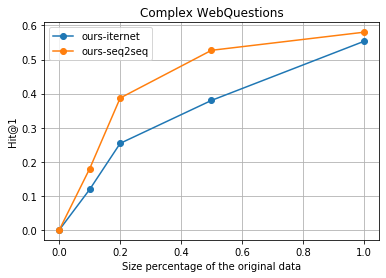

In [8]:

x1 = [0, 0.1, 0.2, 0.5, 1]
y1 = [0, 0.119, 0.254, 0.38, 0.553]
x2 = [0, 0.1, 0.2, 0.5, 1]
y2 = [0, 0.18, 0.387, 0.527, 0.58]

plt.plot(x1, y1, label='ours-iternet', marker='o')
plt.plot(x2, y2, label='ours-seq2seq', marker='o')
# plt.annotate("(23256, 0.551)", (20256 + 300, 0.551))
# plt.annotate("(38000, 0.32)", (38000, 0.32))
# plt.annotate("(62000, 0.459)", (62000, 0.459))

plt.title('Complex WebQuestions')
plt.xlabel('Size percentage of the original data')
plt.ylabel('Hit@1')
plt.legend()
plt.grid('-')
plt.savefig('efficency.png', dpi=300)

In [50]:
print(test_data[54]['sparql'])

PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x
WHERE {
FILTER (?x != ?c)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
?c ns:film.film.starring ?k .
?k ns:film.performance.character ns:m.05m1x3_ . 
?c ns:film.film.starring ?y .
?y ns:film.performance.actor ?x .
?y ns:film.performance.character ns:m.02qd_td .
}



In [5]:
print([e for e in test_data if e['sparql'].count('ORDER') > 0][1]['sparql'])
print()

PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x
WHERE {
FILTER (?x != ?c)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
?c ns:religion.religious_leadership_jurisdiction.leader ?k .
?k ns:religion.religious_organization_leadership.leader ns:m.02qmnw . 
?c ns:location.statistical_region.religions ?y .
?y ns:location.religion_percentage.religion ?x .
?y ns:location.religion_percentage.percentage ?sk0 .
}
ORDER BY DESC(xsd:float(?sk0))
LIMIT 1




In [79]:
for idx in range(20, 40):
    print([e for e in test_data if len(e['entities']) == 2][idx]['sparql'])
    print()

PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x
WHERE {
FILTER (?x != ?c)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
?c ns:film.film.starring ?k .
?k ns:film.performance.character ns:m.0yj6trj . 
?c ns:film.film.starring ?y .
?y ns:film.performance.actor ?x .
?y ns:film.performance.character ns:m.020hj1 .
}


PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x
WHERE {
FILTER (?x != ?c)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
?c ns:location.country.administrative_divisions ns:m.04lj5y . 
?c ns:government.governmental_jurisdiction.governing_officials ?y .
?y ns:government.government_position_held.office_holder ?x .
?y ns:government.government_position_held.basic_title ns:m.060bp .
FILTER(NOT EXISTS {?y ns:government.government_position_held.from ?sk0} || 
EXISTS {?y ns:government.government_position_held.from ?sk1 . 
FILTER(xsd:datetime(?sk1) <= "2015-08-10"^^xsd:dateTime) })
FILTER(NOT EXISTS {?y ns:governm

In [42]:
for e in train_data:
    if len(e['entities']) == 2:
        if 'label' in features[e['entities'][0]] and 'label' in features[e['entities'][1]]:
            print(e['sparql'])
            print(e['entities'][0], features[e['entities'][0]])
            print(e['entities'][1], features[e['entities'][1]])
            print(e['answers'])
            print(features[e['answers'][0]])
            print(set(facts['m.0jmk7']['sports.sports_team_roster.team'].keys()) & 
                  set(facts['m.02_nkp']['sports.pro_athlete.teams'].keys()))
            print(features['m.0j2gtf_'])
            print(e['question'])
            break

PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x
WHERE {
FILTER (?x != ns:m.02_nkp)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
ns:m.02_nkp ns:sports.pro_athlete.teams ?y .
?y ns:sports.sports_team_roster.team ?x .
?x ns:sports.sports_team.championships ns:m.08x9_6 . 
}
m.02_nkp {'label': ['Lamar Odom'], 'types': ['award winner', 'agent', 'animate', 'physically instantiable', 'topic', 'olympic athlete', 'measured person', 'person', 'pro athlete', 'award nominee', 'actor', 'person or entity appearing in film', 'athlete extra', 'basketball player', 'tv personality', 'celebrity', 'social network user', 'topic', 'person extra', 'tv program guest', 'daylife id', 'topic', 'olympic medalist'], 'prom_types': 'celebrities.celebrity'}
m.08x9_6 {'label': ['1980 NBA Finals'], 'types': ['base.type_ontology.abstract', 'base.type_ontology.inanimate', 'base.type_ontology.non_agent', 'common.topic', 'time.event', 'book.book_subject', 'sports.sports_championship_ev

In [29]:
print(train_data[36]['sparql'])

PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x
WHERE {
FILTER (?x != ?c)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
?c ns:people.person.places_lived ?k .
?k ns:people.place_lived.location ns:m.025s1y5 . 
?c ns:people.person.religion ?x .
}



In [30]:
features['m.025s1y5']

{'types': ['location.location',
  'architecture.structure',
  'architecture.building',
  'projects.project_focus',
  'symbols.name_source'],
 'prom_types': ['architecture.structure']}

In [17]:
features = load_json(cfg['data_folder'] + 'features.json')

In [ ]:
#### total = 0
wrong = 0
for e in test_data:
    sparql = e['sparql']
    if sparql.count('FILTER') > 2 or sparql.count('ORDER') > 0:
        print(sparql)
        wrong += 1
        break
print((1 - wrong / len(test_data)) * 0.72)

In [4]:
train_ground_truth = load_json(cfg['data_folder'] + 'train_grounded_queries.json')
dev_ground_truth = load_json(cfg['data_folder'] + 'dev_grounded_queries.json')
test_ground_truth = load_json(cfg['data_folder'] + 'test_grounded_queries.json')

In [7]:
train_ids = {e['ID'] for e in train_data}
dev_ids = {e['ID'] for e in dev_data}
test_ids = {e['ID'] for e in test_data}

In [8]:
all_path = load_json(cfg['data_folder'] + 'all_questions_v3.json')

In [14]:
facts = load_json(cfg['data_folder'] + 'all_facts_all_new2.json')

In [6]:
facts_old = load_json(cfg['data_folder'] + 'all_facts.json')

In [220]:
# Fix facts
for s in tqdm(facts):
    for p in facts[s]:
        for o in facts[s][p]:
            if o not in facts:
                facts[o] = dict()
            if p not in facts[o]:
                facts[o][p] = dict()
            if s not in facts[o][p]:
                facts[o][p][s] = 0 if facts[s][p][o] == 1 else 1

100%|██████████| 7606655/7606655 [00:52<00:00, 144854.88it/s]


In [224]:
save_json(facts, cfg['data_folder'] + 'all_facts_all_new.json')

## Find inference chain

In [13]:
raw_data_map = {}
for q in train_data + dev_data + test_data:
    raw_data_map[q['ID']] = q

In [12]:
for q in all_path:
    if 'all_paths' in q:  
        del q['all_paths']
    if 'path_v2' in q:
        del q['path_v2']
    if 'subgraph' in q:
        del q['subgraph']

In [95]:
len(train_data) + len(dev_data)

34689

In [73]:
TOPIC_ENTITY_RE = re.compile('ns:[mg]\.[a-zA-Z_0-9]*')

In [137]:
for q in all_path:
    raw_data = raw_data_map[q['ID']]
    q['machine_question'] = raw_data['machine_question']

In [230]:
qs = []
for q in all_path:
    flag = False
    for path in q['path']:
        if flag:
            break
        for idx in range(1, len(path) - 1, 2):
            rel = path[idx][0][1]
            if 'common' in rel:
                flag = True
                qs.append(q)
                break
wrong = 0
wrong2 = 0
for q in all_path:
    leads_to_answers = []
    for path in q['path']:
        if len(path) % 2 == 0:
            continue
        leads_to_answer = True
        visited = set()
        for idx in range(0, len(path) - 2, 2):
            s = path[idx]
            if isinstance(s, list):
                visited.update(s)
                s = s[0]
            else:
                visited.add(s)
            p = path[idx+1][0][1]
            if 'common' in p or 'with_no_name_entry' in s:
                break
            o = path[idx+2]
            next_neighbors = set(facts[s][p].keys())
            if len(next_neighbors - visited) != len(set(o)):
                leads_to_answer = False
        leads_to_answers.append(leads_to_answer)
    if sum(leads_to_answers) == 0:
        wrong += 1
        print(q['path'][0])
        print(q['path'][1])
        print(q['sparql'])
        print(q['question'])
        print(q['answers'])
        print(q['entities'])
        print()
        print()
        break
print(wrong)

['m.0hn47qp', [[1, 'sports.sports_team.fight_song']], ['m.01ct6', 'm.01ct6'], [[0, 'sports.sports_team.championships']], ['m.0642vqv', 'm.076yq']]
['m.06x5s', [[1, 'sports.sports_championship_event.championship']], ['m.0642vqv', 'm.076yq']]
PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x ?c
WHERE {
FILTER (?x != ?c)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
?c ns:sports.sports_team.fight_song ns:m.0hn47qp . 
?c ns:sports.sports_team.championships ?x .
?x ns:sports.sports_championship_event.championship ns:m.06x5s .
}

What year did the team with Baltimore Fight Song win the Superbowl?
[{'aliases': ['Super Bowl 2013', 'Super Bowl 47'], 'answer': 'Super Bowl XLVII', 'answer_id': 'm.0642vqv'}, {'aliases': [], 'answer': 'Super Bowl XXXV', 'answer_id': 'm.076yq'}]
['m.0hn47qp', 'm.06x5s']


1


In [229]:
facts['m.01ct6']['sports.sports_team.championships']

{'m.0_gtz8t': 0, 'm.0_gt_qt': 0, 'm.076yq': 0, 'm.0642vqv': 0, 'm.018fzs': 1}

In [198]:
# Fix the knowledge base to include the correct path
for q in all_path:
    for path in q['path']:
        if len(path) % 2 == 0:
            continue
        for idx in range(0, len(path) - 2, 2):
            ss = path[idx]
            if not isinstance(ss, list):
                ss = [ss]
            p = path[idx+1][0][1]
            os = path[idx+2]
            for s in ss:
                if s not in facts:
                    facts[s] = dict()
                if p not in facts[s]:
                    facts[s][p] = dict()
                for o in os:
                    if o not in facts[s][p]:
                        facts[s][p][o] = 0
            for o in os:
                if o not in facts:
                    facts[o] = dict()
                if p not in facts[o]:
                    facts[o][p] = dict()
                for s in ss:
                    if s not in facts[o][p]:
                        facts[o][p][s] = 1

In [200]:
save_json(facts, cfg['data_folder'] + 'all_facts_v3.json')

In [201]:
len(facts)

7606701

In [14]:
for q in all_path:
    q_rel_path = defaultdict(list)
    for path in q['path']:
        if len(path) % 2 == 0:
            continue
        for idx in range(0, len(path) - 2, 2):
            s = path[idx]
            if isinstance(s, list):
                s = s[0]
            p = path[idx+1][0][1]
            if 'common' in p or 'with_no_name_entry' in s:
                continue
            q_rel_path[idx // 2].append(p)
    q['stage_rel_path'] = q_rel_path

In [263]:
avg_recall = 0.0
count = 0
for q in all_path:
    entities = q['entities']
    cand_rels = set()
    for entity in entities:
        for rel in list(facts[entity].keys())[:200]:
            cand_rels.add(rel)
    targets = set(q['stage_rel_path'][0])
    avg_recall += len(cand_rels & targets) / len(targets) if targets else 1
    count += 1
print(avg_recall / count)

0.9998025390587375


In [28]:
facts['m.02_8yfs']

{'m.0g39h': 1,
 'm.06mtq': 1,
 'm.07cfx': 1,
 'm.05fly': 1,
 'm.0chgr2': 1,
 'm.0847q': 1}

In [65]:
wrong = 0
for q in all_path:
    if not q['stage_rel_path'] or not set(q['stage_rel_path'][0]):
        wrong += 1
#         print(q['question'])
#         print(q['sparql'])
#         print(q['path'])
#         print(q['answers'])
#         print(q['entities'])
#         print(len(q['answers']))
        entities = list(set(q['entities']))
        ground_truths = train_ground_truth[q['ID']]
        
        ground_truth_path_to_entities = defaultdict(list)
        for idx, gt in enumerate(ground_truths):
            g = nx.json_graph.node_link_graph(gt['graph'])
            g = nx.Graph(g)
            g = g.to_undirected()
            answer = gt['answer'].strip()
            for topic_entity in entities:
                try:
                    topic_entity = topic_entity.strip()
                    answer = answer.strip()
                    ground_answer_path = list(nx.all_simple_paths(g, topic_entity, answer))
                    if len(ground_answer_path) > 0:
                        ground_truth_path_to_entities[idx].append(topic_entity)
                except Exception as e:
                    print(e)
                    continue
#             for s, o, p in g.edges(data='label'):
#                 if s in entities or o in entities:
#                     print(p)
        print(ground_truth_path_to_entities)
        break
print(wrong)

NameError: name 'all_path' is not defined

In [255]:
len(facts['m.018fzs'])

680

39.28191643067676


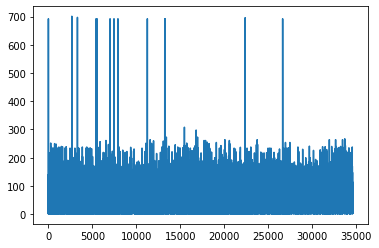

In [249]:
import matplotlib.pyplot as plt

cand_rel_lens = [len(q['cand_rels']) for q in all_path]
plt.plot(cand_rel_lens)
print(np.mean(cand_rel_lens))

In [238]:
new_train_data = [e for e in all_path if e['ID'] in train_ids]
new_dev_data = [e for e in all_path if e['ID'] in dev_ids]
new_test_data = [e for e in all_path if e['ID'] in test_ids]
save_json(new_train_data, cfg['data_folder'] + 'train_iternet.json')
save_json(new_dev_data, cfg['data_folder'] + 'train_iternet.json')
save_json(new_test_data, cfg['data_folder'] + 'train_iternet.json')

# Fix the ground truth of all_path

In [47]:
all_path[0]

{'ID': 'WebQTrn-3513_7c4117891abf63781b892537979054c6',
 'answers': [{'aliases': ['Washington D.C.',
    'Washington',
    'The District',
    'U.S. Capital',
    'District of Columbia / Washington city',
    'The District of Columbia',
    'District of Columbia',
    'Washington DC'],
   'answer': 'Washington, D.C.',
   'answer_id': 'm.0rh6k'}],
 'composition_answer': 'george washington university',
 'compositionality_type': 'composition',
 'question': "What state is home to the university that is represented in sports by George Washington Colonials men's basketball?",
 'entities': ['m.03d0l76'],
 'sparql': "PREFIX ns: <http://rdf.freebase.com/ns/>\nSELECT DISTINCT ?x ?c ?y\nWHERE {\nFILTER (?x != ?c)\nFILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))\n?c ns:education.educational_institution.sports_teams ns:m.03d0l76 . \n?c ns:organization.organization.headquarters ?y .\n?y ns:location.mailing_address.state_province_region ?x .\n}\n",
 'path': [['m.03d0l76',
   [

In [9]:
all_ground_truths = dict()
all_ground_truths.update(train_ground_truth)
all_ground_truths.update(dev_ground_truth)
all_ground_truths.update(test_ground_truth)

In [73]:
new_ground_truths = dict()

In [74]:
for q in tqdm(all_path):
    entities = list(set(q['entities']))
    ground_truths = all_ground_truths[q['ID']]
    for idx, gt in enumerate(ground_truths):
        g = nx.json_graph.node_link_graph(gt['graph'])
        g = nx.Graph(g)
        g = g.to_undirected()
        answer = gt['answer']
        graph_topic_entities = set()
        for topic_entity in entities:
            try:
                topic_entity = topic_entity.strip()
                answer = answer.strip()
                ground_answer_path = list(nx.all_simple_paths(g, topic_entity, answer))
                if len(ground_answer_path) > 0:
                    graph_topic_entities.add(topic_entity)
                gt['entities'] = list(graph_topic_entities)
            except Exception as e:
                continue
    new_ground_truths[q['ID']] = ground_truths

100%|██████████| 34606/34606 [00:14<00:00, 2355.03it/s]


In [149]:
# Fix new path
for q in tqdm(all_path):
    q_id = q['ID']
    ground_truths = new_ground_truths[q_id]
    path = []
    all_paths = []
    for gt in ground_truths:
        g = nx.json_graph.node_link_graph(gt['graph'])
        g = nx.Graph(g)
        answer = gt['answer'].strip()
        entities = gt['entities']
        for topic_entity in entities:
            gt_paths = list(nx.all_simple_paths(g, topic_entity, answer))
            for path in map(nx.utils.pairwise, gt_paths):
                tmp_path = []
                path_list = list(path)
                for i, p in enumerate(path_list):
                    s = p[0]
                    o = p[1]
                    edge_label = g.get_edge_data(p[0], p[1])['label']
                    if i == 0:
                        tmp_path.append(s)
                    tmp_path.append(edge_label)
                    tmp_path.append(o)
                all_paths.append(tmp_path)
    q['new_path'] = all_paths

100%|██████████| 34606/34606 [00:10<00:00, 3261.95it/s]


In [154]:
idx = 0
q = all_path[idx]
print(q['question'])
print(q['entities'])
print(q['answers'])
for e in q['entities']:
    print(facts[e].keys())
print(q['sparql'])
print(q['new_path'])

What state is home to the university that is represented in sports by George Washington Colonials men's basketball?
['m.03d0l76']
[{'aliases': ['Washington D.C.', 'Washington', 'The District', 'U.S. Capital', 'District of Columbia / Washington city', 'The District of Columbia', 'District of Columbia', 'Washington DC'], 'answer': 'Washington, D.C.', 'answer_id': 'm.0rh6k'}]
dict_keys(['base.marchmadness.ncaa_tournament_seed.team', 'base.marchmadness.ncaa_basketball_tournament_game.losing_team', 'sports.sports_team_roster.team', 'sports.team_venue_relationship.team', 'sports.sports_facility.teams', 'base.marchmadness.ncaa_basketball_tournament_game.winning_team', 'basketball.basketball_coach.team', 'basketball.basketball_division.teams', 'education.athletics_brand.teams', 'sports.sports_team.colors', 'basketball.basketball_conference.teams', 'sports.sport.teams', 'education.educational_institution.sports_teams', 'common.topic.notable_types'])
PREFIX ns: <http://rdf.freebase.com/ns/>
SELE

In [161]:
facts['m.0cnnz2d']['location.mailing_address.state_province_region']

{'m.0rh6k': 0}

# Walk from the topic entity to the answer, and see if there are ambious roads

In [257]:
wrong = 0
for q in tqdm(all_path[10:100]):
    print(q['question'])
    print(q['sparql'])
    print()
#     print(q['ID'])
#     print('topic', q['entities'])
#     print('answers', list(map(lambda x: x['answer_id'], q['answers'])))
    ans2right = defaultdict(bool)
    for ans in list(map(lambda x: x['answer_id'], q['answers'])):
        ans2right[ans] = False
    correct_path = []
    for path in paths:
        visited = set()
        tmp_wrong = False
#         print('new_path', path)
        for idx in range(0, len(path)-2, 2):
            s = path[idx]
            p = path[idx+1]
            o = path[idx+2]
            visited.add(s)
            if s not in facts or p not in facts[s]:
                tmp_wrong = True
                continue
            next_neighbors = set(facts[s][p].keys())
            if len(next_neighbors - visited) != 1:
                tmp_wrong = True
                break
        if not tmp_wrong:
            ans2right[path[-1]] = True
            correct_path.append(path)
    if sum((ans2right.values())) < len(ans2right):
        wrong += 1
print(wrong)

100%|██████████| 90/90 [00:00<00:00, 10976.02it/s]

The artist from the HIStory World Tour concert tour played what character on the Wiz?
PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x ?c ?y
WHERE {
FILTER (?x != ?c)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
?c ns:music.artist.concert_tours ns:m.09x1nf . 
?c ns:film.actor.film ?y .
?y ns:film.performance.character ?x .
?y ns:film.performance.film ns:m.027fwmt .
}


What team with mascot named Champ did Tyson Chandler play for?
PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x ?y
WHERE {
FILTER (?x != ns:m.05j8c8)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
ns:m.05j8c8 ns:sports.pro_athlete.teams ?y .
?y ns:sports.sports_team_roster.team ?x .
?x ns:sports.sports_team.team_mascot ns:m.0kh6jz4 . 
}

Who was the creator of the communist party that had Parkinson's disease?
PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x 
WHERE {
FILTER (?x != ns:m.02189)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR lan

In [228]:
all_path[1]['correct_path']

[]

In [260]:
set(facts['m.02xt6q']['sports.pro_athlete.teams'].keys())

{'m.02k_bcp', 'm.02sf29t', 'm.0jyw9hw', 'm.0jyw9j6'}

{'directed': True, 'multigraph': True, 'graph': {'id': 'WebQTrn-2136_d95da5fb8a16d81fe56cd4ce00843254'}, 'nodes': [{'id': 'm.0642vqv'}, {'id': 'm.01ct6'}, {'id': 'm.0hn47qp'}, {'id': 'm.06x5s'}], 'links': [{'label': 'NotEquals', 'source': 'm.0642vqv', 'target': 'm.01ct6', 'key': 0}, {'label': 'sports.sports_championship_event.championship', 'source': 'm.0642vqv', 'target': 'm.06x5s', 'key': 0}, {'label': 'sports.sports_team.fight_song', 'source': 'm.01ct6', 'target': 'm.0hn47qp', 'key': 0}, {'label': 'sports.sports_team.championships', 'source': 'm.01ct6', 'target': 'm.0642vqv', 'key': 0}]}
{'directed': True, 'multigraph': True, 'graph': {'id': 'WebQTrn-2136_d95da5fb8a16d81fe56cd4ce00843254'}, 'nodes': [{'id': 'm.076yq'}, {'id': 'm.01ct6'}, {'id': 'm.0hn47qp'}, {'id': 'm.06x5s'}], 'links': [{'label': 'NotEquals', 'source': 'm.076yq', 'target': 'm.01ct6', 'key': 0}, {'label': 'sports.sports_championship_event.championship', 'source': 'm.076yq', 'target': 'm.06x5s', 'key': 0}, {'label': 

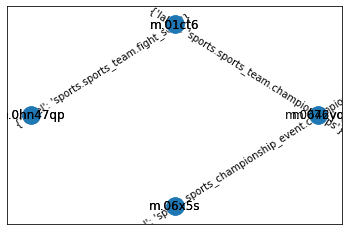

In [589]:
for gt in train_ground_truth['WebQTrn-2136_d95da5fb8a16d81fe56cd4ce00843254']:
    g = nx.json_graph.node_link_graph(gt['graph'])
    pos = nx.circular_layout(g)
    nx.draw_networkx_labels(g, pos)
    nx.draw_networkx_nodes(g, pos)
    nx.draw_networkx_edge_labels(g, pos)

In [ ]:
for q in all_path:
    paths = q['new_path']
    for path in paths:

## Load mid features

In [176]:
all_features = dict()
for file_name in tqdm(os.listdir('/home/hxssg1124/Developer/astar/ASTAR-complexQA/complexQA/data/features/')):
    file_path = os.path.join('/home/hxssg1124/Developer/astar/ASTAR-complexQA/complexQA/data/features/', file_name)
    r = load_json(file_path)
    all_features.update(r)

100%|██████████| 94/94 [02:44<00:00,  1.75s/it]


In [180]:
all_features['m.06mkj']

{'types': ['user.robert.earthquakes.earthquake_epicenter',
  'location.country',
  'location.location',
  'location.statistical_region',
  'location.dated_location',
  'business.business_location',
  'business.employer',
  'book.book_subject',
  'organization.organization_founder',
  'sports.sports_team_location',
  'government.governmental_jurisdiction',
  'film.film_location',
  'location.administrative_division',
  'royalty.kingdom',
  'organization.organization_scope',
  'olympics.olympic_participating_country',
  'organization.organization_member',
  'user.robert.military.military_power',
  'media_common.netflix_genre',
  'symbols.flag_referent',
  'periodicals.newspaper_circulation_area',
  'travel.travel_destination',
  'military.military_combatant',
  'user.tsegaran.random.taxonomy_subject',
  'food.beer_country_region',
  'royalty.system_of_nobility',
  'biology.breed_origin',
  'sports.sport_country',
  'user.skud.legal.treaty_signatory',
  'user.skud.boats.naval_combatant'],

In [299]:
idx = 31301
print(all_path[idx]['question'])
print(all_path[idx]['sparql'])
print(all_path[idx]['answers'])

A person who was once born in Gingins was born where?
PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x ?c ?k
WHERE {
FILTER (?x != ?c)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
?c ns:people.person.places_lived ?k .
?k ns:people.place_lived.location ns:m.09nx79 . 
?c ns:people.person.place_of_birth ?x .
}



KeyError: 'answers'

## Fix Groundtruth

In [358]:
wrong = 0
for q in train_data:
    gt = train_ground_truth[q['ID']]
    answers = list(set(e['answer'].strip() for e in gt))
    if answers:
        q['answers'] = answers
    else:
        q['answers'] = list(e['answer_id'] for e in q['answers'])
for q in dev_data:
    gt = dev_ground_truth[q['ID']]
    answers = list(set(e['answer'].strip() for e in gt))
    if answers:
        q['answers'] = answers
    else:
        q['answers'] = list(e['answer_id'] for e in q['answers'])
for q in test_data:
    gt = test_ground_truth[q['ID']]
    answers = list(set(e['answer'].strip() for e in gt))
    q['answers'] = answers
    
    
save_json(train_data, cfg['data_folder'] + 'complex_train_processed.json')
save_json(dev_data, cfg['data_folder'] + 'complex_dev_processed.json')
save_json(test_data, cfg['data_folder'] + 'complex_test_processed.json')

In [341]:
wrong = 0
wrong2 = 0
for idx, q in enumerate(new_train_data):
    gt = train_ground_truth[q['ID']]
    answers = set(e['answer'].strip() for e in gt)
    if set(q['answers']) != set(e['answer_id'] for e in train_data[idx]['answers']):
#         print(q['sparql'])
#         print(q['answers'])
#         print(train_data[idx]['answers'])
        wrong += 1
    if answers != set(q['answers']):
        wrong2 += 1
        if wrong2 > 5:
            print(q['sparql'])
            print(q['answers'])
            print(train_data[idx]['answers'])
            break
    
print(wrong)
print(wrong2)

PREFIX ns: <http://rdf.freebase.com/ns/>
SELECT DISTINCT ?x
WHERE {
FILTER (?x != ?c)
FILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))
?c ns:organization.organization.child ?k .
?k ns:organization.organization_relationship.child ns:m.09mqm6y . 
?c ns:organization.organization.headquarters ?y .
?y ns:location.mailing_address.citytown ?x .
}

[]
[{'aliases': ['Milwaukee, Wisconsin', 'Waukesha County / Milwaukee city'], 'answer': 'Milwaukee', 'answer_id': 'm.0dyl9'}]
6
6


In [361]:
for q in test_data:
    if 'answers' not in q or not q['answers']:
        print(q['ID'])
        print(q['sparql'])

In [475]:
wrong = 0
wrong_ql = []
avg_cover_answer_recall = 0.0

def is_mid(entity):
    return entity.startswith('ns:m.') or entity.startswith('ns:g.') or entity.startswith('?')

for i, q in tqdm(enumerate(train_data + dev_data + test_data)):
    sparql = q['sparql']
    sparql = sparql.replace('{', '{\n').replace('}', '\n}\n')
    related_triples = []
    for idx, line in enumerate(sparql.split('\n')):
        if not line.strip():
            continue
        line = line.strip()
        if line.startswith('ns:') or line.startswith('?'):
            related_triples.append(tuple(line.split()[:3]))
    local_kb = defaultdict(dict)
    topic_entities = set()
    first_element_complete_triple = None
    for t in related_triples:
        if len(t) > 2 and (t[2].strip() == '.' or t[2].strip() == ';'):
            t = (t[0], t[1])
        if len(t) == 3:
            first_element_complete_triple = t[0]
        if len(t) < 3:
            t = (first_element_complete_triple, t[0], t[1])
        if not is_mid(t[0]) or not is_mid(t[2]):
            continue
        if t[0].startswith('ns:'):
            topic_entities.add(''.join(t[0][3:]))
        elif t[2].startswith('ns:'):
            topic_entities.add(''.join(t[2][3:]))
        t_0 = t[0].replace('ns:', '')
        t_2 = t[2].replace('ns:', '')
        t_1 = t[1].replace('ns:', '')
        local_kb[t_2][t_0] = t_1
        local_kb[t_0][t_2] = t_1
    topic_entities = list(topic_entities)
    q['entities'] = topic_entities
    if 'education.university' in topic_entities:
        print(sparql)
        break
    first_hop_relations = set()
    first_hop_entities = set()
    second_hop_relations = set()
    second_hop_entities = set()
    third_hop_relations = set()
    third_hop_entities = set()
    visited = set()
    for topic_entity in topic_entities:
        visited.add(topic_entity)
        for ie in local_kb[topic_entity]:
            first_hop_entities.add(ie)
            first_hop_relations.add(local_kb[topic_entity][ie])
    for topic_entity in first_hop_entities:
        if topic_entity in visited:
            continue
        visited.add(topic_entity)
        for ie in local_kb[topic_entity]:
            second_hop_entities.add(ie)
            second_hop_relations.add(local_kb[topic_entity][ie])
    for topic_entity in second_hop_entities:
        if topic_entity in visited:
            continue
        visited.add(topic_entity)
        for ie in local_kb[topic_entity]:
            third_hop_entities.add(ie)
            third_hop_relations.add(local_kb[topic_entity][ie])
    first_hop_relations = list(first_hop_relations)
    second_hop_relations = list(second_hop_relations)
    third_hop_relations = list(third_hop_relations)
    q['rel_
      _multi'] = [first_hop_relations, second_hop_relations , third_hop_relations]
    recall = len((first_hop_entities | second_hop_entities | third_hop_entities) & set(['?x'])) == 1
    avg_cover_answer_recall += recall
print(avg_cover_answer_recall / len(train_data + dev_data + test_data))

34689it [00:00, 48809.67it/s]

0.9652627634120327


In [476]:
wrong = 0
avg_first_hop_relations = 0
avg_second_hop_relations = 0
avg_third_hop_relations = 0
for q in train_data + dev_data + test_data:
    if 'rel_cands_multi' not in q:
        wrong += 1
    elif not q['rel_cands_multi']:
        wrong += 1
    avg_first_hop_relations += len(q['rel_cands_multi'][0])
    avg_second_hop_relations += (len(q['rel_cands_multi'][1]) if len(q['rel_cands_multi']) > 1 else 0)
    avg_third_hop_relations += (len(q['rel_cands_multi'][2]) if len(q['rel_cands_multi']) > 2 else 0)
avg_first_hop_relations /= (len(train_data + dev_data +test_data))
avg_second_hop_relations /= (len(train_data + dev_data +test_data))
avg_third_hop_relations /= (len(train_data + dev_data +test_data))
print(avg_first_hop_relations)
print(avg_second_hop_relations)
print(avg_third_hop_relations)

1.519934273112514
2.6760068033094067
1.2115656259909482


In [573]:
len_cands = []
avg_recall = 0
for q in train_data + dev_data + test_data:
    entities = q['entities']
    adj_relations = set()
    for entity in entities:
        for adj_relation in facts[entity]:
            adj_relations.add(adj_relation)
    ground_rels = q['rel_cands_multi'][0]
    recall = len(set(ground_rels) & adj_relations) / len(ground_rels) if len(ground_rels) > 0 else 0
    adj_relations = list(adj_relations)
    #q['rel_cands_multi_cands'] = adj_relations
    len_cands.append(len(adj_relations))
    avg_recall += recall
    if recall < 1:
        print(ground_rels)
        print(entities)
        break
avg_recall /= len(train_data + dev_data + test_data)
print(np.mean(len_cands))
print(avg_recall)

['base.aareas.schema.administrative_area.administrative_children', 'location.country.administrative_divisions', 'base.aareas.schema.administrative_area.administrative_area_type']
['m.07ssc', 'm.0hzjlmp', 'm.02dv8y']
47.46153846153846
0.0007399079439207434


In [577]:
facts['m.02dv8y']['base.aareas.schema.administrative_area.administrative_children']

KeyError: 'base.aareas.schema.administrative_area.administrative_children'

In [496]:
test_data[1]

{'ID': 'WebQTrn-2136_d95da5fb8a16d81fe56cd4ce00843254',
 'answers': ['m.0642vqv', 'm.076yq'],
 'composition_answer': 'baltimore ravens',
 'compositionality_type': 'composition',
 'created': '2018-02-12T23:27:26',
 'machine_question': 'what year did the sports team with the fight song The Baltimore Fight Song win the superbowl',
 'question': 'What year did the team with Baltimore Fight Song win the Superbowl?',
 'sparql': "PREFIX ns: <http://rdf.freebase.com/ns/>\nSELECT DISTINCT ?x\nWHERE {\nFILTER (?x != ?c)\nFILTER (!isLiteral(?x) OR lang(?x) = '' OR langMatches(lang(?x), 'en'))\n?c ns:sports.sports_team.fight_song ns:m.0hn47qp . \n?c ns:sports.sports_team.championships ?x .\n?x ns:sports.sports_championship_event.championship ns:m.06x5s .\n}\n",
 'webqsp_ID': 'WebQTrn-2136',
 'webqsp_question': 'what year did baltimore ravens win the superbowl',
 'entities': ['m.0hn47qp', 'm.06x5s'],
 'rel_cands_multi': [['sports.sports_team.fight_song',
   'sports.sports_championship_event.champion

In [498]:
save_json(train_data, 'complex_train_processed.json')
save_json(dev_data, 'complex_dev_processed.json')
save_json(test_data, 'complex_test_processed.json')

In [395]:
"""
?x ns:common.topic.notable_types ns:m.02h76fz . # Military Conflict
      ?x ns:time.event.start_date ?from . 
      ?x ns:time.event.end_date ?to . 
      ?x ns:military.military_conflict.combatants ?y .
      ?y ns:military.military_combatant_group.combatants ns:m.09c7w0 .  # United States of America
"""
print(facts['m.09c7w0']['military.military_combatant_group.combatants'])
# set(facts['m.02h76fz']['common.topic.notable_types'].keys()) & set(facts['m.09c7w0']['military.military_combatant_group.combatants'])

KeyError: 'military.military_combatant_group.combatants'

In [518]:
for e in train_data:
    for multi in e['rel_cands_multi']:
        for rel in multi:
            if rel not in relation2id:
                print(rel)
                relation2id[rel] = len(relation2id)

american_football.football_historical_coach_position.to
american_football.football_historical_coach_position.from
base.biblioness.bibs_location.loc_type
base.events.event_feed.type_of_event
zoos.zoo.opened
sports.sports_team_roster.to
sports.sports_team_roster.from
government.government_position_held.to
government.government_position_held.from
topic_server.population_number
time.event.start_date
time.event.end_date
people.place_lived.start_date
people.place_lived.end_date
base.unitednations.united_nations_body_membership.from
base.unitednations.united_nations_body_membership.to
people.marriage.from
people.marriage.to
architecture.structure.construction_started
sports.team_venue_relationship.from
sports.team_venue_relationship.to
architecture.museum.established
award.award_honor.year
architecture.structure.opened
sports.pro_athlete.career_start
music.album.release_date
measurement_unit.dated_percentage.rate
measurement_unit.dated_integer.number
law.judicial_tenure.to_date
law.judicial_t

In [519]:
len(relation2id)

8594

In [555]:
wrong = 0
for idx in range(len(train_data)):
    for multi in train_data[idx]['rel_cands_multi']:
        for rel in multi:
            if 'common' in rel:
                wrong += 1
                break

In [520]:
with open('datasets/complexwebq/relations.txt', 'w') as f:
    for e in relation2id:
        f.writelines(e + '\n')

In [569]:
lens = []
for e in test_data:
    lens.append(len(e['rel_cands_multi_cands']))

In [570]:
np.max(lens)

296

## Check question and relation vocabulary

In [537]:
# check question vocab
total_words = set()
for q in tqdm(train_data):
    q_words = clean_text(q['question'])
    total_words.update(q_words)

100%|██████████| 27639/27639 [00:01<00:00, 26959.83it/s]


In [530]:
print(len(set(word2id.keys()) & total_words) / len(total_words))

0.9948761742100769


In [538]:
# check relation vocab
for rel in tqdm(relation2id):
    q_words = clean_text(rel, True)
    total_words.update(q_words)

100%|██████████| 8594/8594 [00:00<00:00, 23832.33it/s]


In [543]:
with open('datasets/complexwebq/vocab.txt', 'w') as f:
    for e in sorted(total_words):
        f.writelines(e + '\n')

## Fix Missing facts data

In [598]:
# Replace variable with actual intermediate entity.
recall = 0

def is_mid(entity):
    return entity.startswith('ns:m.') or entity.startswith('ns:g.') or entity.startswith('?')

for i, q in tqdm(enumerate(train_data + dev_data + test_data)):
    sparql = q['sparql']
    sparql = sparql.replace('{', '{\n').replace('}', '\n}\n')
    related_triples = []
    for idx, line in enumerate(sparql.split('\n')):
        if not line.strip():
            continue
        line = line.strip()
        if line.startswith('ns:') or line.startswith('?'):
            related_triples.append(tuple(line.split()[:3]))
    local_kb = defaultdict(dict)
    topic_entities = set()
    first_element_complete_triple = None
    related_relations = set()
    for t in related_triples:
        if len(t) > 2 and (t[2].strip() == '.' or t[2].strip() == ';'):
            t = (t[0], t[1])
        if len(t) == 3:
            first_element_complete_triple = t[0]
        if len(t) < 3:
            t = (first_element_complete_triple, t[0], t[1])
        if not is_mid(t[0]) or not is_mid(t[2]):
            continue
        if t[0].startswith('ns:'):
            topic_entities.add(''.join(t[0][3:]))
        elif t[2].startswith('ns:'):
            topic_entities.add(''.join(t[2][3:]))
        t_0 = t[0].replace('ns:', '')
        t_2 = t[2].replace('ns:', '')
        t_1 = t[1].replace('ns:', '')
        related_relations.add(t_1)
#         print(t_0, t_1, t_2)
    gt_relations = set()
    gts = all_ground_truths[q['ID']]
    for gt in gts:
        g = nx.json_graph.node_link_graph(gt['graph'])
        for graph_triple in g.edges(data='label'):
            gt_s, gt_p, gt_o = graph_triple[0], graph_triple[2], graph_triple[1]
#             print(gt_s, gt_p, gt_o)
            gt_relations.add(gt_p)
    recall += len(gt_relations & related_relations) / len(related_relations)
print(recall / len(train_data + dev_data + test_data))

34689it [00:05, 5835.96it/s]

0.9997982069243853


In [602]:
facts['m.020h2v'].keys()

dict_keys(['film.film.production_companies', 'film.film_film_distributor_relationship.distributor', 'organization.organization.place_founded', 'award.award_nomination.award_nominee', 'common.image.appears_in_topic_gallery', 'organization.organization.headquarters', 'business.industry.companies', 'organization.organization_relationship.parent', 'award.award_honor.award_winner', 'cvg.computer_videogame.publisher', 'cvg.game_version.publisher', 'business.company_type.companies_of_this_type', 'organization.organization_relationship.child', 'organization.organization_type.organizations_of_this_type', 'common.topic.notable_types', 'business.employment_tenure.company', 'business.company_name_change.company', 'organization.organization_founder.organizations_founded', 'film.production_company.films', 'film.film_distributor.films_distributed', 'cvg.cvg_publisher.games_published', 'award.award_nominee.award_nominations', 'business.employer.employees', 'award.award_winner.awards_won', 'common.topi

## Fix ground truth data

In [662]:
for idx, q in tqdm(enumerate(train_data + dev_data + test_data)):
    gts = all_ground_truths[q['ID']]
    topics = q['entities']
    all_paths = set()
    for gt in gts:
        g = nx.json_graph.node_link_graph(gt['graph'])
        g = g.to_undirected()
        answer = gt['answer'].strip()
        for topic in topics:
            try:
                paths = nx.all_simple_paths(g, topic, answer)
                for path in map(nx.utils.pairwise, paths):
                    tmp_path = []
                    path_list = list(path)
                    flag = False
                    for i, p in enumerate(path_list):
                        # Filter special relations
                        s = p[0]
                        o = p[1]
                        edge_label = g.get_edge_data(s, o)[0]['label']
                        if edge_label in ('Equals', 'GreaterThan', 'GreaterThanOrEqual', 'LessThan', 'LessThanOrEqual', 'NotEquals'):
                            flag = True
                        if i == 0:
                            tmp_path.append(s)
                        tmp_path.append(edge_label)
                        tmp_path.append(o)
                    if not flag:
                        all_paths.add(tuple(tmp_path))
            except Exception as e:
                continue
        # Loop answer
        if answer in topics:
            for e in g.edges(data='label'):
                if (e[0] == answer or e[1] == answer) and e[2] not in ('Equals', 'GreaterThan', 'GreaterThanOrEqual', 'LessThan', 'LessThanOrEqual', 'NotEquals'):
                    all_paths.add((answer, e[2], answer))
                    break
    all_paths = list(all_paths)
    q['ground_truth_path'] = all_paths 

34689it [00:14, 2427.44it/s]


In [629]:
for idx, q in tqdm(enumerate(train_data + dev_data + test_data)):
    if not q['ground_truth_path']:
        print(idx)

34689it [00:00, 1862995.36it/s]

508
1112
2123
3136
9930
10669
10881
13193
14919
17372
17484
18786
21467
23879
24766


In [115]:
for qid, gts in tqdm(all_ground_truths.items()):
    for gt in gts:
        g = nx.json_graph.node_link_graph(gt['graph'])
        for e in g.edges(data='label'):
            s, o, p = e
            if s not in facts:
                facts[s] = dict()
            if p not in facts[s]:
                facts[s][p] = dict()
            if o not in facts[s][p]:
                facts[s][p][o] = 0
            if o not in facts:
                facts[o] = dict()
            if p not in facts[o]:
                facts[o][p] = dict()
            if s not in facts[o][p]:
                facts[o][p][s] = 1

100%|██████████| 34689/34689 [00:05<00:00, 6711.81it/s]


In [117]:
save_json(facts, cfg['data_folder'] + 'all_facts_all_new2.json')

In [120]:
all_rels = set()
for k in tqdm(facts):
    for k2 in facts[k]:
        all_rels.add(k2)

100%|██████████| 7624604/7624604 [00:07<00:00, 1072836.66it/s]


In [122]:
all_rels = list(sorted(all_rels))

In [123]:
with open('datasets/complexwebq/relations.txt', 'w') as f:
    for e in all_rels:
        f.writelines(e + '\n')

## Set ground truth relation paths.

In [771]:
# Set ground truth relation paths
for e in tqdm(train_data + dev_data + test_data):
    rel_cands_multi = []
    for gt_path in e['ground_truth_path']:
        i_range = list(range(1, len(gt_path) - 1, 2))
        for idx, i in enumerate(i_range):
            rel = [gt_path[i_idx] for i_idx in i_range[:(idx+1)]]
            rel_hop = i // 2
            if rel_hop >= len(rel_cands_multi):
                rel_cands_multi.append(set())
            rel_cands_multi[rel_hop].add(tuple(rel))
            
    rel_cands_multi = list(map(lambda x: list(x), rel_cands_multi))
    e['rel_cands_multi'] = rel_cands_multi

100%|██████████| 34689/34689 [00:00<00:00, 98544.49it/s]


In [779]:
# Set candidate relation paths
len_cands = []
avg_recall1 = 0
avg_recall2 = 0
avg_recall3 = 0
wrong = 0
for q in (train_data + dev_data + test_data):
    if not q['rel_cands_multi']:
        wrong += 1
        avg_recall += 1
        continue
    if 'rel_cands_multi_cands' in q:
        del q['rel_cands_multi_cands']
    # first hop
    # entities = q['entities']
    entities1 = set()
    entities2 = set()
    entities3 = set()
    filter_rels = {'Equals', 'GreaterThan', 'GreaterThanOrEqual', 'LessThan', 'LessThanOrEqual', 'NotEquals'}
    for gt_path in q['ground_truth_path']:
        if len(gt_path) > 4:
            entities3.add((gt_path[4], gt_path[3], gt_path[1]))
        if len(gt_path) > 2:
            entities2.add((gt_path[2], gt_path[1]))
        entities1.add(gt_path[0])
    adj_relations1 = set()
    for entity in entities1:
        for adj_relation in facts[entity]:
            adj_relations1.add((adj_relation,))
    adj_relations2 = set()
    for entity in entities2:
        for adj_relation in facts[entity[0]]:
            if entity[1] not in filter_rels:
                adj_relations2.add((entity[1], adj_relation))
    adj_relations3 = set()
    for entity in entities3:
        for adj_relation in facts[entity[0]]:
            if entity[2] not in filter_rels:
                adj_relations3.add((entity[2], entity[1], adj_relation))
    adj_relations1 -= filter_rels
#     ground_rels1 = q['rel_cands_multi'][0]
#     ground_rels2 = q['rel_cands_multi'][1] if len(q['rel_cands_multi']) > 1 else ['EOD']
#     ground_rels3 = q['rel_cands_multi'][2] if len(q['rel_cands_multi']) > 2 else ['EOD']
#     recall1 = len(set(ground_rels1) & adj_relations1) / len(ground_rels1) if len(ground_rels1) > 0 else 1
#     recall2 = len(set(ground_rels2) & adj_relations2) / len(ground_rels2) if len(ground_rels2) > 1 else 1
#     recall3 = len(set(ground_rels3) & adj_relations3) / len(ground_rels3) if len(ground_rels3) > 2 else 1
    adj_relations1 = list(adj_relations1)
    adj_relations2 = list(adj_relations2)
    adj_relations3 = list(adj_relations3)
    q['rel_cands_multi_cands1'] = adj_relations1
    q['rel_cands_multi_cands2'] = adj_relations2
    q['rel_cands_multi_cands3'] = adj_relations3
#     avg_recall1 += recall1
#     avg_recall2 += recall2
#     avg_recall3 += recall3

avg_recall1 /= len(train_data + dev_data + test_data)
avg_recall2 /= len(train_data + dev_data + test_data)
avg_recall3 /= len(train_data + dev_data + test_data)
print(np.mean(len_cands))
print(avg_recall1)
print(avg_recall2)
print(avg_recall3)

nan
0.0
0.0
0.0


In [781]:
train_data[0]['rel_cands_multi'][0]

[('education.educational_institution.sports_teams',)]

In [782]:
save_json(train_data, cfg['data_folder'] + 'complex_train_processed.json')
save_json(dev_data, cfg['data_folder'] + 'complex_dev_processed.json')
save_json(test_data, cfg['data_folder'] + 'complex_test_processed.json')

In [651]:
print(cfg['data_folder'] + 'complex_train_processed.json')

datasets/complexwebq/complex_train_processed.json


In [726]:
# Step 1-hop recall:
avg_recall = 0.0
for e in train_data + dev_data + test_data:
    rel_cands_multi = e['rel_cands_multi']
    gt_rels = set(e2 for e in rel_cands_multi for e2 in e)
    cands_rels = set(e['rel_cands_multi_cands'])
    recall = len(cands_rels & gt_rels) / len(gt_rels) if len(gt_rels) > 0 else 1
    avg_recall += recall
avg_recall /= len(train_data + dev_data + test_data)
print(avg_recall)

0.7037668040782


In [777]:
train_data[0]['rel_cands_multi_cands1']

['education.educational_institution.sports_teams',
 'sports.sport.teams',
 'base.marchmadness.ncaa_basketball_team.tournament_games_won',
 'base.marchmadness.ncaa_basketball_team.ncaa_tournament_seeds',
 'sports.sports_team.arena_stadium',
 'base.marchmadness.ncaa_tournament_seed.team',
 'basketball.basketball_division.teams',
 'basketball.basketball_conference.teams',
 'sports.sports_team.roster',
 'common.topic.notable_types',
 'sports.sports_team_roster.team',
 'sports.team_venue_relationship.team',
 'sports.sports_facility.teams',
 'education.athletics_brand.teams',
 'basketball.basketball_team.head_coach',
 'base.marchmadness.ncaa_basketball_tournament_game.losing_team',
 'sports.school_sports_team.school',
 'basketball.basketball_coach.team',
 'sports.sports_team.colors',
 'base.marchmadness.ncaa_basketball_team.tournament_games_lost',
 'base.marchmadness.ncaa_basketball_tournament_game.winning_team']

In [695]:
# Step 2-hop recall:
avg_recall = 0.0
avg_recall2 = 0.0
len_cands = []
for e in train_data + dev_data + test_data:
    if not e['ground_truth_path']:
        continue
    hop2_entities = list(set([gp[2] for gp in e['ground_truth_path']]))
    gt_2hop_rels = set()
    for gp in e['ground_truth_path']:
        if len(gp) < 4:
            continue
        gt_2hop_rels.add(gp[3])
    
    rel_cands_multi = e['rel_cands_multi']
    gt_rels = set(e2 for e in rel_cands_multi for e2 in e)
    cands_rels = set(e['rel_cands_multi_cands'])
    
    for hop2_e in hop2_entities:
        for rel in facts[hop2_e]:
            cands_rels.add(rel)
    
    len_cands.append(len(cands_rels))
    recall = len(cands_rels & gt_rels) / len(gt_rels) if len(gt_rels) > 0 else 1
    recall2 = len(cands_rels & gt_2hop_rels) / len(gt_2hop_rels) if len(gt_2hop_rels) > 0 else 1
    avg_recall += recall
    avg_recall2 += recall2
avg_recall /= len(train_data + dev_data + test_data)
avg_recall2 /= len(train_data + dev_data + test_data)
print(avg_recall)
print(avg_recall2)
print(np.mean(len_cands))

0.9438698146386998
0.9995675862665399
96.2461786929688


In [ ]:
# Step 3-hop recall:
avg_recall = 0.0
for e in train_data + dev_data + test_data:
    if not e['ground_truth_path']:
        continue
    hop2_entities = list(set([gp[2] for gp in e['ground_truth_path']]))
    
    rel_cands_multi = e['rel_cands_multi']
    gt_rels = set(e2 for e in rel_cands_multi for e2 in e)
    cands_rels = set(e['rel_cands_multi_cands'])
    
    for hop2_e in hop2_entities:
        for rel in facts[hop2_e]:
            cands_rels.add(rel)
    
    recall = len(cands_rels & gt_rels) / len(gt_rels) if len(gt_rels) > 0 else 1
    avg_recall += recall
avg_recall /= len(train_data + dev_data + test_data)
print(avg_recall)

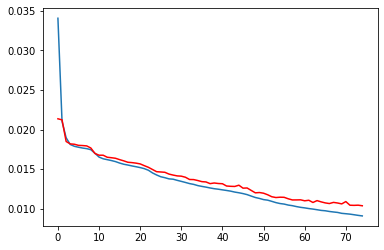

In [692]:
train_loss = []
valid_loss = []
with open('progress.txt') as f:
    lines = f.readlines()
    for e in lines:
        e = e.strip()
        if e.startswith('avg_training_loss'):
            train_loss.append(float(e.split()[1]))
        if 'avg_loss' in e:
            if e.index('avg_loss') == 0:
                valid_loss.append(float(e.split()[1]))
            else:
                valid_loss.append(float(''.join(e[56:])))
plt.plot(train_loss)
plt.plot(valid_loss, 'r')
plt.show()

## Setup input of entity predictor

In [4]:
base_path = 'datasets/complexwebq/features'
all_features = dict()
for p in tqdm(os.listdir(base_path)):
    f_dir = os.path.join(base_path, p)
    f_features = load_json(f_dir)
    all_features.update(f_features)

100%|██████████| 94/94 [02:48<00:00,  1.79s/it]


In [11]:
save_features = dict()
for e in facts:
    if e in all_features:
        save_features[e] = all_features[e]

In [13]:
save_json(save_features, 'datasets/complexwebq/features.json')

In [75]:
max_max_len = 0
for idx, e in tqdm(enumerate((train_data + dev_data + test_data))):
    if 'rel_cands_multi' in e:
        del e['rel_cands_multi']
    if 'rel_cands_multi_cands1' in e:
        del e['rel_cands_multi_cands1']
    if 'rel_cands_multi_cands2' in e:
        del e['rel_cands_multi_cands2']
    if 'rel_cands_multi_cands3' in e:
        del e['rel_cands_multi_cands3']
    if 'entities1' in e:
        del e['entities1']
    if 'entities2' in e:
        del e['entities2']
    if 'entities3' in e:
        del e['entities3']
    if 'ground_truth_map' in e:
        del e['ground_truth_map']
    if 'ground_truth_cands_1' in e:
        del e['ground_truth_cands_1']
    if 'ground_truth_cands_2' in e:
        del e['ground_truth_cands_2']
    if 'ground_truth_cands_3' in e:
        del e['ground_truth_cands_3']
    block_rels = {'Equals', 'GreaterThan', 'GreaterThanOrEqual', 'LessThan', 'LessThanOrEqual', 'NotEquals'}
    entities1 = set()
    entities2 = set()
    entities3 = set()
    for gtp in e['ground_truth_path']:
        if len(gtp) > 0:
            entities1.add((gtp[0],))
        if len(gtp) > 2:
            entities2.add((gtp[2], gtp[1]))
        if len(gtp) > 4:
            entities3.add((gtp[4], gtp[1], gtp[3]))
    entities1 = list(entities1)
    entities2 = list(entities2)
    entities3 = list(entities3)
    e['entities1'] = entities1
    e['entities2'] = entities2
    e['entities3'] = entities3
    
    #FIX EOD special relationship.
    rel_cands_multi_map = defaultdict(set)
    for gt_path in e['ground_truth_path']:
        i_range = list(range(1, len(gt_path) - 1, 2))
#         print('gp___: ', gt_path)
        for idx, i in enumerate(i_range):
            rel = [gt_path[i_idx] for i_idx in i_range[:(idx+1)]]
            rel_hop = i // 2
            cur_entity = gt_path[i - 1]
            rel_cands_multi_map['%s___%d' % (cur_entity, rel_hop)].add(tuple(rel))
    rel_cands_multi_map = {k: list(v) for k, v in rel_cands_multi_map.items()}
    for k in rel_cands_multi_map.keys():
        k_spt = k.split('___')[1]
        
    e['ground_truth_map'] = rel_cands_multi_map
    
    adj_relations1 = dict()
    for entity in entities1:
        adj_relations1_tmp = set()
        for adj_relation in facts[entity[0]]:
            adj_relations1_tmp.add((adj_relation,))
        adj_relations1_tmp -= block_rels
        adj_relations1[entity[0]] = list(adj_relations1_tmp)
    adj_relations2 = dict()
    for entity in entities2:
        adj_relations2_tmp = set()
        for adj_relation in facts[entity[0]]:
            if entity[1] not in block_rels:
                adj_relations2_tmp.add((entity[1], adj_relation))
        adj_relations2_tmp.add((entity[1], 'EOD'))
        adj_relations2[entity[0]] = list(adj_relations2_tmp)
    adj_relations3 = dict()
    for entity in entities3:
        adj_relations3_tmp = set()
        for adj_relation in facts[entity[0]]:
            if entity[2] not in block_rels:
                adj_relations3_tmp.add((entity[2], entity[1], adj_relation))
        adj_relations3_tmp.add((entity[2], entity[1], 'EOD'))
        adj_relations3[entity[0]] = list(adj_relations3_tmp)
    
#     max_len = max([len(e) for e in rel_cands_multi_map.values()])
#     max_max_len = max(max_max_len, max_len)
    e['ground_truth_cands_1'] = adj_relations1
    e['ground_truth_cands_2'] = adj_relations2
    e['ground_truth_cands_3'] = adj_relations3
#     print('adj_relations1', adj_relations1)
#     print('adj_relations2', adj_relations2)
    print('adj_relations3', adj_relations3)
    break
#     print(max_len)
#     print('-------------------------')
#     print()
# print(max_max_len)
#         print(entities2)
#         print(entities3)
#         print(e['ground_truth_path'])

1it [00:00, 1558.64it/s]

gt: [['m.0hn47qp', 'sports.sports_team.fight_song', 'm.01ct6', 'sports.sports_team.championships', 'm.0642vqv'], ['m.0hn47qp', 'sports.sports_team.fight_song', 'm.01ct6', 'sports.sports_team.championships', 'm.076yq'], ['m.06x5s', 'sports.sports_championship_event.championship', 'm.076yq'], ['m.06x5s', 'sports.sports_championship_event.championship', 'm.0642vqv']]
adj_relations2 {'m.076yq': [('sports.sports_championship_event.championship', 'time.recurring_event.instances'), ('sports.sports_championship_event.championship', 'user.dylanrocks.national_football_league.super_bowl_site.super_bowl'), ('sports.sports_championship_event.championship', 'sports.sports_team.championships'), ('sports.sports_championship_event.championship', 'sports.sports_championship_event.season'), ('sports.sports_championship_event.championship', 'sports.sports_league_season.championship'), ('sports.sports_championship_event.championship', 'time.event.end_date'), ('sports.sports_championship_event.championship'

In [263]:
# new method
avg_recall = 0
recall_cnt = 0
avg_recall2 = 0
recall_cnt2 = 0
avg_len_cands = 0
total_len_cands = 0
for idx, e in tqdm(enumerate((train_data + dev_data + test_data))):
    if 'rel_cands_multi' in e:
        del e['rel_cands_multi']
    if 'rel_cands_multi_cands1' in e:
        del e['rel_cands_multi_cands1']
    if 'rel_cands_multi_cands2' in e:
        del e['rel_cands_multi_cands2']
    if 'rel_cands_multi_cands3' in e:
        del e['rel_cands_multi_cands3']
    if 'entities1' in e:
        del e['entities1']
    if 'entities2' in e:
        del e['entities2']
    if 'entities3' in e:
        del e['entities3']
    if 'ground_truth_map' in e:
        del e['ground_truth_map']
    if 'ground_truth_cands_1' in e:
        del e['ground_truth_cands_1']
    if 'ground_truth_cands_2' in e:
        del e['ground_truth_cands_2']
    if 'ground_truth_cands_3' in e:
        del e['ground_truth_cands_3']
    if 'rel_chaim_map' in e:
        del e['rel_chaim_map']
    if 'rel_chain_entity_map' in e:
        del e['rel_chain_entity_map']
    block_rels = {'Equals', 'GreaterThan', 'GreaterThanOrEqual', 'LessThan', 'LessThanOrEqual', 'NotEquals'}
#     print(e['sparql'])
    
    rel_chain_map = dict()
    rel_chain_entity_map = dict()
    for hop in range(1, 5):
        rel_chain_with_hop_map =  dict()
        rel_chain_entity_with_hop_map = dict()
        # Find the following relations based on the previous entity-relation chain.
        local_entity_rel_chain_map = defaultdict(set)
        # Find the intermediate entities based on the topic entity with the given hop
        local_entity_inter_entities_map = defaultdict(set)
        for gt in e['ground_truth_path']:
            topic_entity = gt[0]
            target_relation = gt[2*hop-1] if (2*hop-1 < len(gt)) else 'EOD'
            prev_relations = [(gt[idx] if idx < len(gt) else 'EOD') for idx in range(1, 2*hop-1, 2)]
#             if 'EOD' in prev_relations:
#                 continue
            local_entity_rel_chain_map[topic_entity].add(tuple(prev_relations + [target_relation]))
            if 2*(hop-1) < len(gt):
                local_entity_inter_entities_map[topic_entity].add(tuple([gt[2*(hop-1)]] + [gt_e for idx_e, gt_e in enumerate(gt[:2*(hop-1)]) if idx_e % 2 == 1]))
#         print('hop:', hop)
#         print('local_entity_rel_chain_map', local_entity_rel_chain_map)
#         print('entitysssss:', entities)
        for k, v in local_entity_rel_chain_map.items():
#             print('entity:', entity)
            rel_chain_with_hop_entity_map = dict()
            ground_truth = list(v)
#             print('asdasdasd',ground_truth)
            new_cand_rels = set()
            for inter_entity_prev_relations in local_entity_inter_entities_map[k]:
                inter_entity = inter_entity_prev_relations[0]
                prev_relations = inter_entity_prev_relations[1:]
                temp_rels = set(facts[inter_entity].keys())
                temp_rels = list(filter(lambda x: x not in block_rels, temp_rels))
                temp_rels.append('EOD')
                temp_rels = set(map(lambda x: tuple(list(prev_relations) + [x]), temp_rels))
                new_cand_rels.update(temp_rels)
            new_cand_rels = list(new_cand_rels)
            
            rel_chain_with_hop_entity_map['ground_truth'] = ground_truth
            rel_chain_with_hop_entity_map['cands'] = list(new_cand_rels)
            avg_len_cands += len(new_cand_rels)
            total_len_cands += 1
            rel_chain_with_hop_map[k] = rel_chain_with_hop_entity_map
            
            recall = len(set(new_cand_rels) & set([tuple(e) for e in ground_truth])) / len(ground_truth)
#             if recall < 1:
#                 print(idx)
#                 print(new_cand_rels)
#                 print('-----------------------------------')
#                 print(ground_truth)
#                 print()
#                 asdsdsds
            avg_recall += recall
            recall_cnt += 1
        rel_chain_map[hop] = rel_chain_with_hop_map
#         print()
    e['rel_chain_map'] = rel_chain_map
#     print(rel_chain_map)
    #e['rel_chain_entity_map'] = rel_chain_entity_map
#     break
            
#     for k, v in rel_chain_map.items():
#         print('%s--> %s' % (k, v))
print(avg_recall / recall_cnt)
print(avg_len_cands / total_len_cands)
    

34689it [00:05, 5855.38it/s]

0.6955073521513021
30.169655551553525


In [264]:
save_json(train_data, cfg['data_folder'] + 'complex_train_processed_new2.json')
save_json(dev_data, cfg['data_folder'] + 'complex_dev_processed_new2.json')
save_json(test_data, cfg['data_folder'] + 'complex_test_processed_new2.json')

In [226]:
print(train_data[25]['rel_chain_entity_map'])

{1: {'m.07ssc|||base.aareas.schema.administrative_area.administrative_children': {'ground_truth': ['m.05bcl'], 'cands': ['m.0j5g9', 'm.02jx1', 'm.05bcl', 'm.06q1r']}, 'm.02dv8y|||location.country.administrative_divisions': {'ground_truth': ['m.05bcl'], 'cands': ['m.05bcl']}, 'm.0hzjlmp|||base.aareas.schema.administrative_area.administrative_area_type': {'ground_truth': ['m.05bcl'], 'cands': ['m.05bcl', 'm.06q1r', 'm.02jx1', 'm.0j5g9']}}, 2: {}, 3: {}}


In [196]:
facts['m.03q1lvy']['location.religion_percentage.religion']

{'m.092bf5': 0}

In [194]:
facts['m.01c_w6']['religion.religion.sacred_sites']

{'m.092bf5': 1}

In [203]:
avg_entity = 0
avg_recall = 0
total = 0
for q in test_data:
    for gt in q['ground_truth_path']:
        s = gt[0]
        p = gt[1]
        o = gt[2]
        next_hop_ents = set(list(facts[s][p].keys())[:50])
        avg_recall += 1 if o in next_hop_ents else 0
        avg_entity += len(next_hop_ents)
        total += 1
print(avg_entity / total)
print(avg_recall / total)

16.87120177534995
0.8247695459201092


# New Check facts

In [229]:
# Check if all objects with the same predicate have the same direction
flag = False
for s in facts:
    if flag:
        break
    for p in facts[s]:
        if flag:
            break
        prev_direction = None
        for o in facts[s][p]:
            direction = facts[s][p][o]
            if prev_direction is None:
                prev_direction = direction
            elif direction != prev_direction:
                print(s, p, o)
                flag = True
print(flag)

m.0f4yh media_common.adapted_work.adaptations m.0j9qgt6
True


In [230]:
facts['m.0f4yh']['media_common.adapted_work.adaptations']

{'m.02pst7z': 1, 'm.0j9qgt6': 0}

In [259]:
lens_gt = defaultdict(int)
for idx, e in tqdm(enumerate((train_data + dev_data + test_data))):
    for gt in e['ground_truth_path']:
        lens_gt[(len(gt) - 1) // 2] += 1
print(lens_gt)

34689it [00:00, 610054.68it/s]

defaultdict(<class 'int'>, {3: 31197, 2: 57361, 1: 28143, 4: 21879, 6: 3, 5: 270})


In [269]:
train_data[1]['rel_chain_map']

{1: {'m.0hn47qp': {'ground_truth': [('sports.sports_team.fight_song',)],
   'cands': [('sports.sports_team.fight_song',),
    ('common.topic.notable_types',),
    ('EOD',)]},
  'm.06x5s': {'ground_truth': [('sports.sports_championship_event.championship',)],
   'cands': [('time.recurring_event.instances',),
    ('freebase.type_profile.equivalent_topic',),
    ('freebase.equivalent_topic.equivalent_type',),
    ('symbols.namesake.named_after',),
    ('book.written_work.subjects',),
    ('tv.the_colbert_report_episode.intro_topics',),
    ('sports.sports_championship.events',),
    ('symbols.name_source.namesakes',),
    ('time.recurring_event.current_frequency',),
    ('common.image.appears_in_topic_gallery',),
    ('common.topic.image',),
    ('sports.sports_championship_event.championship',),
    ('book.book_subject.works',),
    ('sports.sports_championship.league',),
    ('freebase.valuenotation.is_reviewed',),
    ('business.business_operation.major_customer',),
    ('base.yupgrade